# Identifying Plumes from AOD and Fire Location

IMPORTANT: Run the function cell located at the bottom of the workbook before running any other cell 

Fires are often associatied with a plume, which will have likely have higher optical depth than the surrounding background and likely spatially connected to a fire cluster.  For a given fire cluster, if we can identify the background level of AOD (and its variance), we can apply this as a threshold to discrimiate plumes through a flood filling approach progressing from the highest AOD pixel associated with the fire cluster including all those pixels above the background.  

Undesirable plumes, with multiple sources for example, can be excluded through postprocessing.

In [35]:
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy.signal
from skimage.measure import label, regionprops
from sklearn.cluster import DBSCAN
import cartopy
import cartopy.crs as ccrs

import sys
sys.path.append("../")
import src.data.tools as tools

In [3]:
# Load in AOD and GEO data for test file:
path = '/Volumes/INTENSO/kcl-ltss-bioatm/raw/reprojected_viirs/aod_classifier_test'
aod_fname = 'IVAOT_npp_d20150706_t0603097_e0604339_b19108_c20150706075934735034_noaa_ops.h5'
geo_fname = 'GMTCO_npp_d20150706_t0603097_e0604339_b19108_c20171126104946623808_noaa_ops.h5'
aod_h5 = h5py.File(os.path.join(path, aod_fname), "r")
geo_h5 = h5py.File(os.path.join(path, geo_fname), "r")

In [4]:
fire_csv = 'fire_archive_V1_26373.csv'
fire_df = pd.read_csv(os.path.join(path, fire_csv))
fire_df['date_time'] = pd.to_datetime(fire_df['acq_date'])

In [5]:
aod = aod_h5['All_Data']['VIIRS-Aeros-Opt-Thick-IP_All']['faot550'][:]
aod_qual = aod_h5['All_Data']['VIIRS-Aeros-Opt-Thick-IP_All']['QF1'][:]
lat = geo_h5['All_Data']['VIIRS-MOD-GEO-TC_All']['Latitude'][:]
lon = geo_h5['All_Data']['VIIRS-MOD-GEO-TC_All']['Longitude'][:]

flag = np.zeros(aod_qual.shape)
for k, v in zip(['00', '01', '10', '11'], [0, 1, 2, 3]):
    mask = read_aod_mask(aod_qual, 0, 2, k)
    flag[mask] = v

In [6]:
# resample AOD to UTM
utm_resampler = tools.utm_resampler(lat, lon, 750)
fv = -999.0

mask = aod < 0
masked_lats = np.ma.masked_array(utm_resampler.lats, mask)
masked_lons = np.ma.masked_array(utm_resampler.lons, mask)

lats_r = utm_resampler.resample_image(utm_resampler.lats, masked_lats, masked_lons, fill_value=fv)
lons_r = utm_resampler.resample_image(utm_resampler.lons, masked_lats, masked_lons, fill_value=fv)
aod_r = utm_resampler.resample_image(aod, masked_lats, masked_lons, fill_value=fv)
flag_r = utm_resampler.resample_image(flag, masked_lats, masked_lons, fill_value=fv)

Reduce to roi with plumes:

In [7]:
ymin = 425
ymax = 850
xmin = 1800
xmax = 2300

aod_r = aod_r[425:850, 1800:2300]
flag_r = flag_r[425:850, 1800:2300]
lats_r = lats_r[425:850, 1800:2300]
lons_r = lons_r[425:850, 1800:2300]

### Subset the fires to the scene

In [8]:
extent = {'min_lat': lats_r.min(),
          'max_lat': lats_r.max(),
          'min_lon': lons_r.min(),
          'max_lon': lons_r.max()}
date_to_find = pd.Timestamp(2015, 7, 6)
image_fires_df = extract_fires_for_roi(fire_df, date_to_find, extent)


/Users/danielfisher/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [9]:
# cluster fires
coords = image_fires_df[['latitude', 'longitude']].values
dist_in_km = 10
db = DBSCAN(eps=dist_in_km/6371., min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
image_fires_df['cluster_id'] = db.labels_

In [10]:
mean_fire_positions = image_fires_df.groupby('cluster_id').agg({'latitude':np.mean, 'longitude': np.mean})

## Display AOD and fires

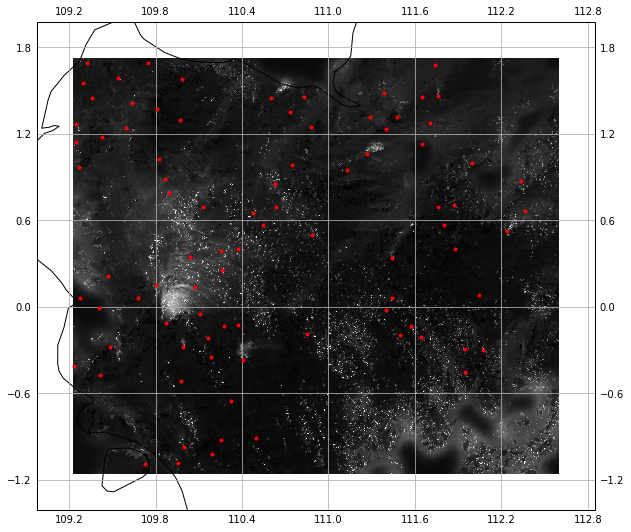

In [11]:
crs = ccrs.PlateCarree()
extent = [np.min(lons_r), np.max(lons_r), np.min(lats_r), np.max(lats_r)]

u_padding = 0.25
l_padding = 1
padded_extent = [np.min(lons_r) - u_padding, np.max(lons_r) + u_padding,
                 np.min(lats_r) - u_padding, np.max(lats_r) + u_padding]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)
ax.set_extent(padded_extent)

ax.coastlines(resolution='50m', color='black', linewidth=1)

gridlines = ax.gridlines(draw_labels=True)
ax.imshow(aod_r, transform=crs, extent=extent, origin='upper', cmap='gray')
ax.plot(mean_fire_positions.longitude, mean_fire_positions.latitude, 'r.')

In [12]:
# Determine which first have a distinct plume in thier local neighbourhood. This can
# be done by local and loval variability.  Take the background as the lowest 10 percent
# a given region, compute the mean & SD of this assumed background, and then see if any pixels
# in the window exceed the mean + 2*SD.  If so, then assume an identifiable plume - else assume
# no plume.  This will help identify between fires in smoke clouds, and fires near the head of
# plumes with a hopefully clear background signal.
y_fire_coords, x_fire_coords = get_image_coords(mean_fire_positions.latitude, mean_fire_positions.longitude, lats_r, lons_r)

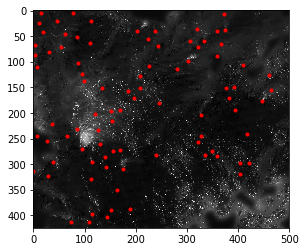

87


In [13]:
plt.imshow(aod_r, cmap='gray')
plt.plot(x_fire_coords,y_fire_coords, 'r.')
plt.show()
print(x_fire_coords.size)

In [14]:
win_size = 7

new_x = []
new_y = []
max_values = []

for y,x in zip(y_fire_coords, x_fire_coords):
    
    
    # get bb and aod
    min_y = y-win_size if y-win_size > 0 else 0 
    max_y = y+win_size+1 if y+win_size+1 < aod_r.shape[0] else aod_r.shape[0]
    min_x = x-win_size if x-win_size > 0 else 0
    max_x = x+win_size+1 if x+win_size+1 < aod_r.shape[1] else aod_r.shape[1]
    aod_for_window = aod_r[min_y:max_y, min_x:max_x]
    flg_for_window = flag_r[min_y:max_y, min_x:max_x]
    
    # keep only windows not on the edge
    if aod_for_window.size != (win_size*2+1)**2:
        continue    
    
    # find background window
    sub_window_means = [] 
    sub_window_sd = []
    step_size = int((win_size*2+1) / 3)
    for i in [0, step_size, step_size*2]:
        for j in [0, step_size, step_size*2]:
            sub_window_aod = aod_for_window[i:i+step_size, j:j+step_size]
            sub_window_flag = flg_for_window[i:i+step_size, j:j+step_size]
            sub_window_means.append(np.mean(sub_window_aod))
    
    min_mean = np.min(sub_window_means)
    max_mean = np.max(sub_window_means)
    
    # The ratio allows us to eliminate fires under smoke clouds, or without clear backgrounds, as
    # the smoke signal needs to be at least a factor of three higher than background.  If all the 
    # background is not clear then it will not be located.
    if max_mean / min_mean > 3:
        new_x.append(x)
        new_y.append(y)
        max_values.append(max_mean)


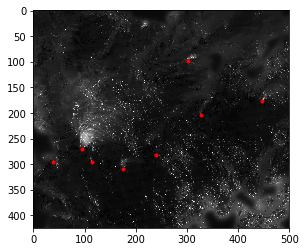

8


In [15]:
plt.imshow(aod_r, cmap='gray')
plt.plot(new_x,new_y, 'r.')
plt.show()
print(len(new_x))

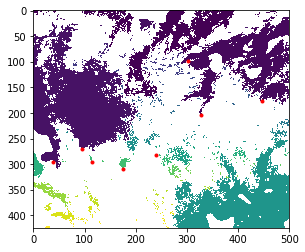

In [16]:
# Any image 
ratio = max_values[4] / aod_r  # todo still need to get this to work for each max value.
mask = ratio <=3

labelled_image, n_labels = label(mask, return_num=True)

# get rid of singleton labels
label_size = [(labelled_image == l).sum() for l in range(n_labels + 1)]
for l,s in enumerate(label_size):
    if s <= 5:
        mask[labelled_image == l] = 0
        labelled_image[labelled_image == l] = 0

im = np.ma.masked_array(labelled_image, labelled_image == 0)
        
plt.imshow(im)
plt.plot(new_x,new_y, 'r.')
plt.show()

Now find nearest label for each fire

In [18]:
# setup the distance matrix.  If no plume within
# five pixel radius then we consider no nearby 
# smoke plume.
window_size = 5
x = np.arange(-window_size, window_size+1)
y = np.arange(-window_size, window_size+1)
dx, dy = np.meshgrid(x, y)
distance_matrix = np.sqrt(dx**2 + dy**2)

# for each fire, get the nearest class
label_nearest_fire = []
for x, y in zip(new_x, new_y):
    labelled_image_subset = labelled_image[y-window_size:y+window_size+1, x-window_size:x+window_size+1]
    label_mask = labelled_image_subset != 0
    
    if label_mask.any():
        labelled_image_subset = labelled_image_subset[label_mask]
        distances = distance_matrix[label_mask]
        
        label_nearest_fire.append(labelled_image_subset[np.argmin(distances)])

print(label_nearest_fire)

# drop fires associated with repeated labels
final_fires_x = []
final_fires_y = []
final_labels = []
for x, y, l in zip(new_x, new_y, label_nearest_fire):
    appearences = np.sum(label_nearest_fire == l)
    if appearences < 2:
        final_fires_x.append(x)
        final_fires_y.append(y)
        final_labels.append(l)

[1382, 1324, 99, 1342, 99, 51, 51, 51]


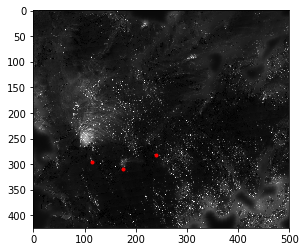

In [36]:
plt.imshow(aod_r, cmap='gray')
plt.plot(final_fires_x,final_fires_y, 'r.')
plt.show()

Now extract the plume for the defined label:

In [26]:
for l in np.unique(labelled_image):
    if l not in final_labels:
        labelled_image[labelled_image == l] = 0


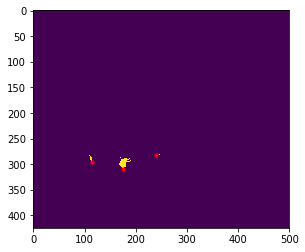

In [37]:
plt.imshow(labelled_image)
plt.plot(final_fires_x,final_fires_y, 'r.')
plt.show()

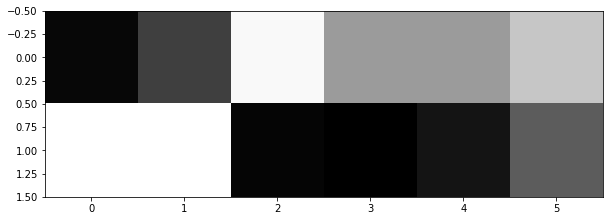

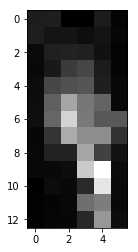

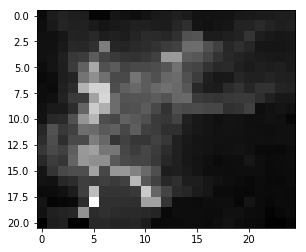

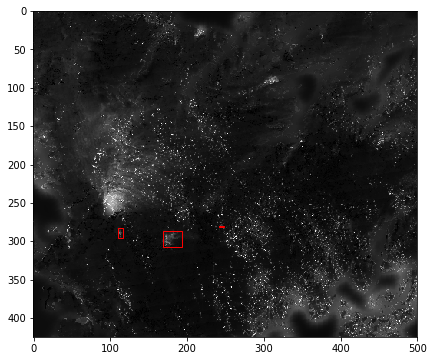

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(aod_r, cmap='gray')

for region in regionprops(labelled_image):
    minr, minc, maxr, maxc = region.bbox
    plt.imshow(aod_r[minr:maxr, minc:maxc], cmap='gray')
    plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(aod_r, cmap='gray')    

for region in regionprops(labelled_image):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
plt.show()

Functions:

In [1]:
def extract_fires_for_roi(df, ts, extent):
    time_subset = df[df.date_time == ts]
    time_space_subset = time_subset[((df.latitude > extent['min_lat']) &
                                    (df.latitude < extent['max_lat']) &
                                    (df.longitude > extent['min_lon']) &
                                    (df.longitude < extent['max_lon']))]
    return time_space_subset

def create_resampler(viirs_data):
    lats = viirs_data['All_Data']['VIIRS-MOD-GEO_All']['Latitude'][:]
    lons = viirs_data['All_Data']['VIIRS-MOD-GEO_All']['Longitude'][:]
    return tools.utm_resampler(lats, lons, 750)


def read_aod_mask(arr, bit_pos, bit_len, value):
    '''Generates mask with given bit information.
    Parameters
        bit_pos		-	Position of the specific QA bits in the value string.
        bit_len		-	Length of the specific QA bits.
        value  		-	A value indicating the desired condition.
    '''
    bitlen = int('1' * bit_len, 2)

    if type(value) == str:
        value = int(value, 2)

    pos_value = bitlen << bit_pos
    con_value = value << bit_pos
    mask = (arr & pos_value) == con_value
    return mask


def get_image_coords(fire_lats, fire_lons, resampled_lats, resampled_lons):
    inverse_lats = resampled_lats * -1  # invert lats for correct indexing

    y_size, x_size = resampled_lats.shape

    min_lat = np.min(inverse_lats[inverse_lats > -1000])
    range_lat = np.max(inverse_lats) - min_lat

    min_lon = np.min(resampled_lons)
    range_lon = np.max(resampled_lons[resampled_lons < 1000]) - min_lon

    # get approximate fire location, remembering to invert the lat
    y = ((fire_lats * -1) - min_lat) / range_lat * y_size
    x = (fire_lons - min_lon) / range_lon * x_size

    return y.astype(int), x.astype(int)